# Preamble

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pet_cli.graphical_analysis as pet_gph
import json
import os
sns.set()
sns.set_style("ticks")
sns.set_context("paper")
plt.rcParams['font.family'] ='StixGeneral'
plt.rcParams['mathtext.fontset'] = 'stix'

# Reading In Parameters

In [2]:
def count_parameter_sets(model_directories: dict) -> dict:
    model_nums = {}
    for model, directory in model_directories.items():
        model_nums[model] = len([f for f in os.listdir(directory) if os.path.splitext(f)[1] == '.json'])
    return model_nums

In [3]:
DIR_PRE = "../../"
model_dirs = {"1tcm":f"{DIR_PRE}data/tcm_tacs/1tcm/",
              "serial_2tcm_k4zero":f"{DIR_PRE}data/tcm_tacs/serial_2tcm_k4zero/",
              "serial_2tcm":f"{DIR_PRE}data/tcm_tacs/serial_2tcm/"}

In [4]:
MODELS_NUMS = count_parameter_sets(model_dirs)
MODELS_NUMS

{'1tcm': 2, 'serial_2tcm_k4zero': 2, 'serial_2tcm': 3}

In [5]:
def safe_load_json(file_path):
    try:
        with open(file_path) as file:
            return json.load(file)
    except Exception as e:
        print(f"Couldn't read file {file_path}. Error: {e}")
        return None

In [6]:
model_params = {
    model: {f'set-{i:02}': safe_load_json(f'{DIR_PRE}data/tcm_tacs/{model}/params_{model}_set-{i:02}.json') for i in
            range(num)} for model, num in MODELS_NUMS.items()}

In [7]:
for model_name, params in model_params.items():
    print(params)
    print()

{'set-00': {'model': '1TCM', 'params': {'k1': 1.0, 'k2': 0.25}}, 'set-01': {'model': '1TCM', 'params': {'k1': 0.25, 'k2': 1.0}}}

{'set-00': {'model': 'Serial 2TCM (k4=0)', 'params': {'k1': 0.5, 'k2': 0.5, 'k3': 0.01}}, 'set-01': {'model': 'Serial 2TCM (k4=0)', 'params': {'k1': 0.5, 'k2': 0.5, 'k3': 0.25}}}

{'set-00': {'model': 'Serial 2TCM', 'params': {'k1': 0.5, 'k2': 0.85, 'k3': 0.01, 'k4': 0.01}}, 'set-01': {'model': 'Serial 2TCM', 'params': {'k1': 0.5, 'k2': 0.85, 'k3': 0.25, 'k4': 0.01}}, 'set-02': {'model': 'Serial 2TCM', 'params': {'k1': 0.5, 'k2': 0.85, 'k3': 0.25, 'k4': 0.15}}}



## Generating Theoretical Values From Parameters

### Patlak Plots

In [8]:
def tcm_1tcm_patlak_slope_and_intercept(model_params: dict) -> dict:
    k1, k2 = model_params['k1'], model_params['k2']
    if k2 == 0.0:
        slope = k1
    else:
        slope = 0.0
    intercept = np.nan
    patlak_slope_intercept = {'slope': slope, 'intercept': intercept}
    return patlak_slope_intercept


def tcm_serial_2tcm_k4zero_patlak_slope_and_intercept(model_params: dict) -> dict:
    k1 = model_params['k1']
    k2 = model_params['k2']
    k3 = model_params['k3']
    slope = (k1 * k3) / (k2 + k3)
    intercept = np.nan
    patlak_slope_intercept = {'slope': slope, 'intercept': intercept}
    return patlak_slope_intercept


def tcm_serial_2tcm_patlak_slope_and_intercept(model_params: dict) -> dict:
    slope = 0.0
    intercept = np.nan
    patlak_slope_intercept = {'slope': slope, 'intercept': intercept}
    return patlak_slope_intercept


def tcm_calculate_patlak_from_model(model_desc: dict) -> dict:
    model = model_desc['model']
    params = model_desc['params']
    if model == '1TCM':
        return tcm_1tcm_patlak_slope_and_intercept(params)
    elif model == 'Serial 2TCM (k4=0)':
        return tcm_serial_2tcm_k4zero_patlak_slope_and_intercept(params)
    elif model == 'Serial 2TCM':
        return tcm_serial_2tcm_patlak_slope_and_intercept(params)
    else:
        return {'slope': np.nan, 'intercept': np.nan}


### Logan Plots

In [9]:
def tcm_1tcm_logan_slope_and_intercept(model_params: dict) -> dict:
    k1, k2 = model_params['k1'], model_params['k2']
    slope = k1 / k2
    intercept = -1.0 / k2
    patlak_slope_intercept = {'slope': slope, 'intercept': intercept, 'ratio': -slope / intercept}
    return patlak_slope_intercept


def tcm_serial_2tcm_logan_slope_and_intercept(model_params: dict) -> dict:
    k1 = model_params['k1']
    k2 = model_params['k2']
    k3 = model_params['k3']
    k4 = model_params['k4']
    slope = (k1 / k2) / (1.0 + k3 / k4)
    intercept = -((1.0 / k2) * (1.0 + k3 / k4) + 1.0 / (k4 + (1.0 + k4 / k3)))
    patlak_slope_intercept = {'slope': slope, 'intercept': intercept, 'ratio': -slope / intercept}
    return patlak_slope_intercept


def tcm_calculate_logan_from_model(model_desc: dict) -> dict:
    model = model_desc['model']
    params = model_desc['params']
    if model == '1TCM':
        return tcm_1tcm_logan_slope_and_intercept(params)
    elif model == 'Serial 2TCM (k4=0)':
        return {'slope': np.nan, 'intercept': np.nan}
    elif model == 'Serial 2TCM':
        return tcm_serial_2tcm_logan_slope_and_intercept(params)
    else:
        return {'slope': np.nan, 'intercept': np.nan, 'ratio': np.nan}


# Comparing Calculated Values With Theoretical Values

### Reading In The Plasma TAC

In [10]:
def safe_load_tac(filename):
    try:
        return np.array(np.loadtxt(filename).T, dtype=float, order='C')
    except Exception as e:
        print(f"Couldn't read file {filename}. Error: {e}")
        return None

In [11]:
pTAC = safe_load_tac('../../data/tcm_tacs/fdg_plasma_clamp_evenly_resampled.txt')

## Noise Free

### Reading In TACs

In [12]:
all_tacs = {}
all_tacs['noise-free'] = {a_model: {f'set-{i:02}': safe_load_tac(
    f'{DIR_PRE}data/tcm_tacs/{a_model}/noise_free/tac_{("_".join(a_model.split("_")[1:]) if "serial_2tcm" in a_model else a_model)}_set-{i:02}.txt')
    for i in range(num)} for a_model, num in MODELS_NUMS.items()}
all_tacs['gaussian-noise'] = {a_model: {f'set-{i:02}': safe_load_tac(
    f'{DIR_PRE}data/tcm_tacs/{a_model}/gaussian_noise/tac_{("_".join(a_model.split("_")[1:]) if "serial_2tcm" in a_model else a_model)}_set-{i:02}.txt')
    for i in range(num)} for a_model, num in MODELS_NUMS.items()}

### Patlak Analysis

#### Code For Plots

In [13]:
def gen_patlak_plot(pTAC, tTAC):
    x = pet_gph.cumulative_trapezoidal_integral(xdata=pTAC[0], ydata=pTAC[1]) / pTAC[1]
    y = tTAC[1]/pTAC[1]
    return np.array([x, y])
    

In [14]:
patlak_xLab = r"$\frac{\int_{0}^{t}C_\mathrm{P}(s)\mathrm{d}s}{C_\mathrm{P}(t)}$"
patlak_yLab = r"$\frac{R(t)}{C_\mathrm{P}(t)}$"

In [15]:
def params_dict_to_label(params):
    tmp = []
    for p, val in params.items():
        tmp.append(f"$k_{{{p[1:]}}}={float(val):<.2f}$")
    return "; ".join(tmp)
params_dict_to_label(model_params['1tcm']['set-00']['params'])

'$k_{1}=1.00$; $k_{2}=0.25$'

#### Plotting

/var/folders/mk/pnrjjqkx6wq8zxfjrfqfst4h0000gp/T/ipykernel_17283/581802919.py:2: RuntimeWarning: invalid value encountered in divide
  x = pet_gph.cumulative_trapezoidal_integral(xdata=pTAC[0], ydata=pTAC[1]) / pTAC[1]
/var/folders/mk/pnrjjqkx6wq8zxfjrfqfst4h0000gp/T/ipykernel_17283/581802919.py:3: RuntimeWarning: invalid value encountered in divide
  y = tTAC[1]/pTAC[1]


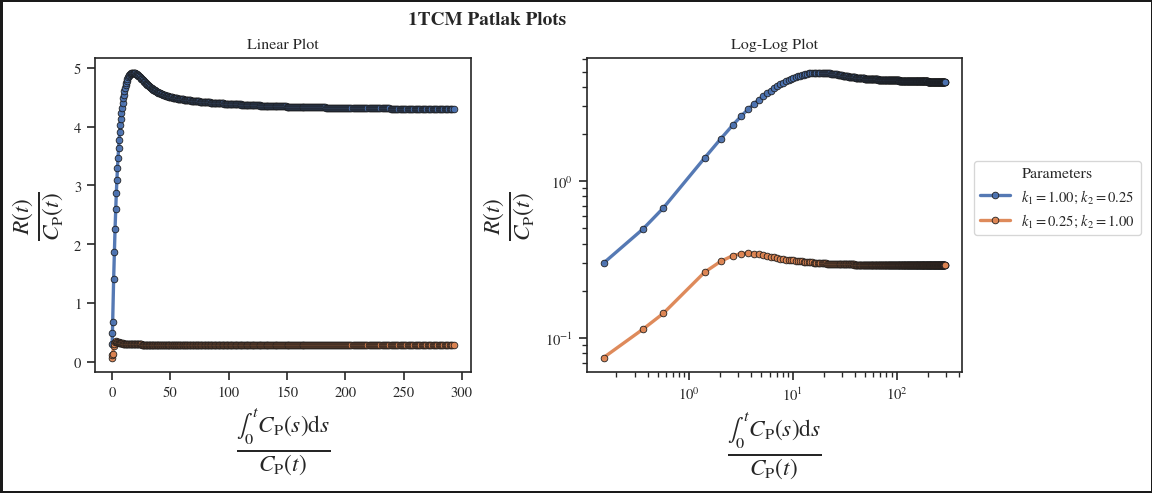

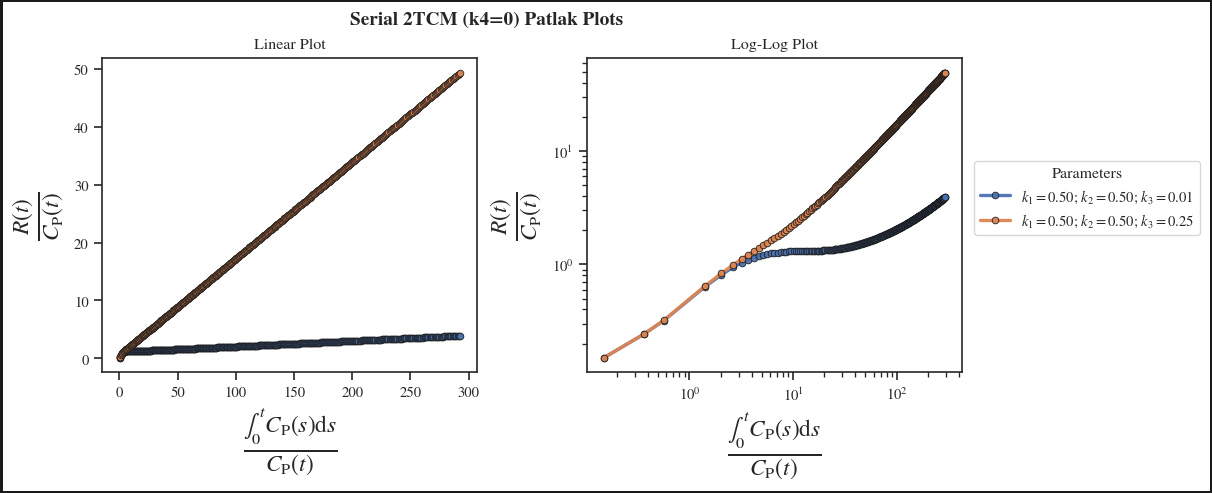

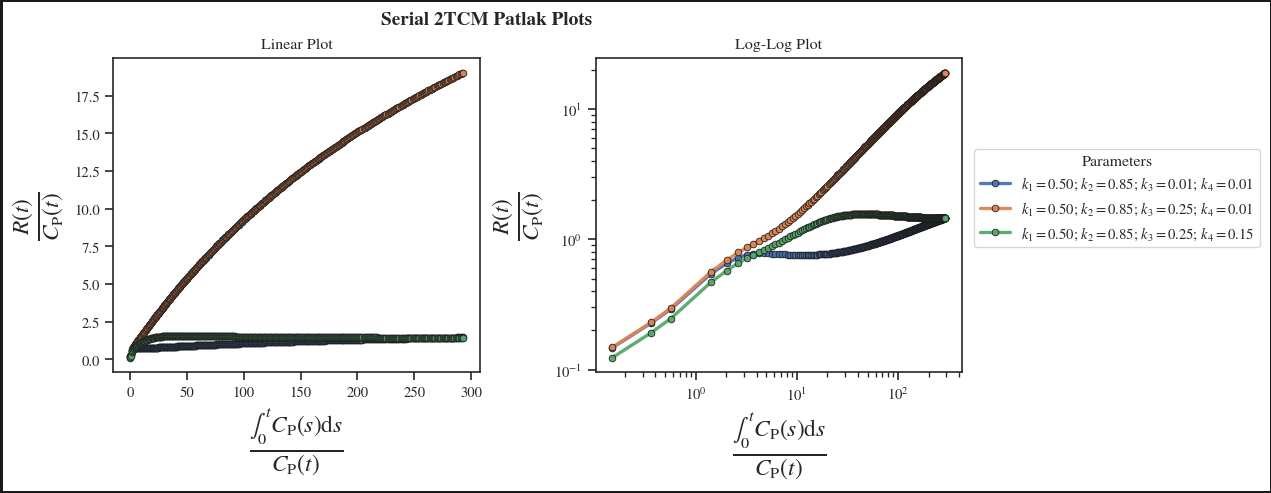

In [16]:
for a_model, num in MODELS_NUMS.items():
    myFig, myAx = plt.subplots(1, 2, constrained_layout=True, figsize=[8, 4], dpi=120, linewidth=3.0, edgecolor='k')
    for i in range(num):
        _params = model_params[a_model][f"set-{i:02}"]
        _tTAC = all_tacs['noise-free'][a_model][f"set-{i:02}"]
        patlak_vars = gen_patlak_plot(pTAC, _tTAC)
        
        myAx[0].plot(*patlak_vars, '.-', alpha=0.95, lw=2, label=params_dict_to_label(_params['params']), color=f"C{i}",
                     ms=8, mec='k', mew=0.5)
        myAx[1].plot(*patlak_vars, '.-', alpha=0.95, lw=2, color=f"C{i}", ms=8, mec='k', mew=0.5)
    
    myAx[0].set(title=f"Linear Plot")
    myAx[1].set(title=f"Log-Log Plot", xscale='log', yscale='log')
    myAx[0].set_xlabel(patlak_xLab, fontsize=20)
    myAx[0].set_ylabel(patlak_yLab, fontsize=20)
    myAx[1].set_xlabel(patlak_xLab, fontsize=20)
    myAx[1].set_ylabel(patlak_yLab, fontsize=20)
    myFig.suptitle(f"{_params['model']} Patlak Plots", fontweight='bold')
    myFig.legend(bbox_to_anchor=(1.0, 0.6), loc='center left', title='Parameters')
    plt.show()

#### Comparing Values

In [17]:
for a_model, num in MODELS_NUMS.items():
    print('-'*35)
    print(f"Model: {a_model}")
    print(f"    {'K1 (true)':<10}, {'K1 (calc)':<10}, {'|diff.|':<10}")
    for i in range(num):
        _params = model_params[a_model][f"set-{i:02}"]
        _tTAC   = all_tacs['noise-free'][a_model][f"set-{i:02}"][1]
        true_vals = tcm_calculate_patlak_from_model(_params)
        calc_vals = pet_gph.patlak_analysis(input_tac_values=pTAC[1],
                                           region_tac_values=_tTAC,
                                           tac_times_in_minutes=pTAC[0],
                                           t_thresh_in_minutes=30.0)
        k1_true = true_vals['slope']
        k1_calc = calc_vals[0]
        diff    = np.abs(k1_true - k1_calc)
        print(f"    {k1_true:<10.5f}, {k1_calc:<10.5f}, {diff:<10.5f}")
    print('-'*35)

-----------------------------------
Model: 1tcm
    K1 (true) , K1 (calc) , |diff.|   
    0.00000   , -0.00070  , 0.00070   
    0.00000   , -0.00001  , 0.00001   
-----------------------------------
-----------------------------------
Model: serial_2tcm_k4zero
    K1 (true) , K1 (calc) , |diff.|   
    0.00980   , 0.00979   , 0.00002   
    0.16667   , 0.16754   , 0.00087   
-----------------------------------
-----------------------------------
Model: serial_2tcm
    K1 (true) , K1 (calc) , |diff.|   
    0.00000   , 0.00233   , 0.00233   
    0.00000   , 0.05626   , 0.05626   
    0.00000   , -0.00049  , 0.00049   
-----------------------------------


### Logan Analysis

#### Plotting Code

In [18]:
def gen_logan_plot(pTAC, tTAC):
    x = pet_gph.cumulative_trapezoidal_integral(xdata=pTAC[0], ydata=pTAC[1]) / tTAC[1]
    y = pet_gph.cumulative_trapezoidal_integral(xdata=tTAC[0], ydata=tTAC[1]) / tTAC[1]
    return np.array([x, y])

def gen_alt_logan_plot(pTAC, tTAC):
    x = pet_gph.cumulative_trapezoidal_integral(xdata=pTAC[0], ydata=pTAC[1]) / pTAC[1]
    y = pet_gph.cumulative_trapezoidal_integral(xdata=tTAC[0], ydata=tTAC[1]) / pTAC[1]
    return np.array([x, y])
    

In [19]:
logan_xLab = r"$\frac{\int_{0}^{t}C_\mathrm{P}(s)\mathrm{d}s}{R(t)}$"
logan_yLab = r"$\frac{\int_{0}^{t}R(s)\mathrm{d}s}{R(t)}$"

#### Plotting

/var/folders/mk/pnrjjqkx6wq8zxfjrfqfst4h0000gp/T/ipykernel_17283/3548088199.py:2: RuntimeWarning: invalid value encountered in divide
  x = pet_gph.cumulative_trapezoidal_integral(xdata=pTAC[0], ydata=pTAC[1]) / tTAC[1]
/var/folders/mk/pnrjjqkx6wq8zxfjrfqfst4h0000gp/T/ipykernel_17283/3548088199.py:3: RuntimeWarning: invalid value encountered in divide
  y = pet_gph.cumulative_trapezoidal_integral(xdata=tTAC[0], ydata=tTAC[1]) / tTAC[1]


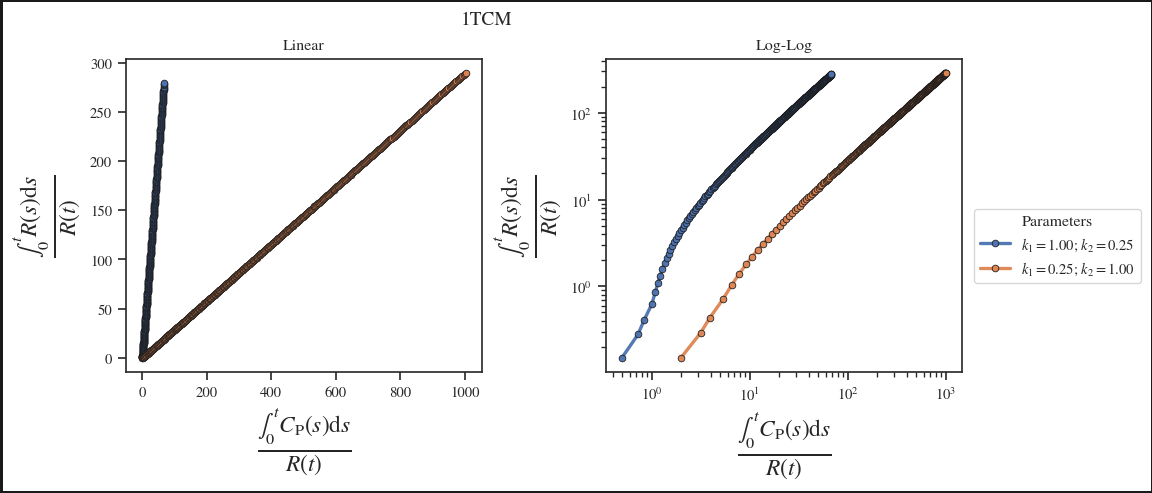

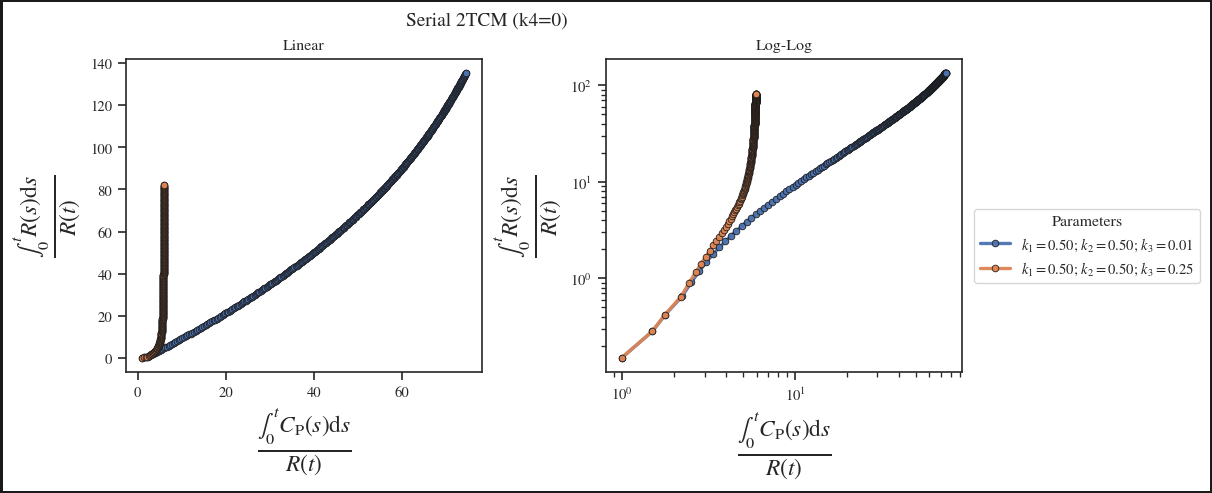

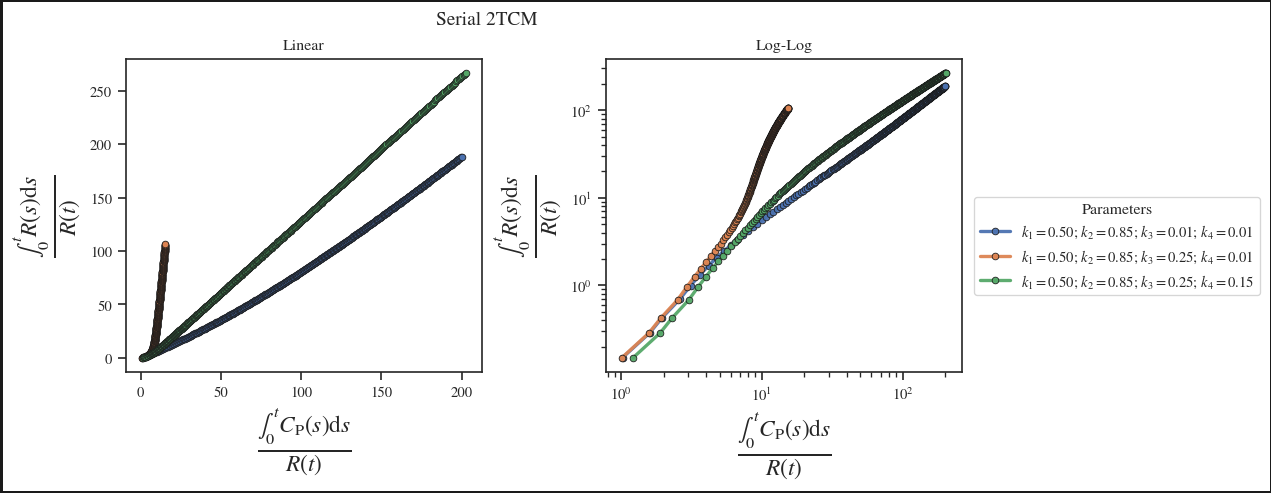

In [20]:
for a_model, num in MODELS_NUMS.items():
    myFig, myAx = plt.subplots(1, 2, constrained_layout=True, figsize=[8, 4], dpi=120, linewidth=3.0, edgecolor='k')
    for i in range(num):
        _params = model_params[a_model][f"set-{i:02}"]
        _tTAC = all_tacs['noise-free'][a_model][f"set-{i:02}"]
        logan_vars = gen_logan_plot(pTAC, _tTAC)
        
        myAx[0].plot(*logan_vars, '.-', alpha=0.95, lw=2, 
                     label=params_dict_to_label(_params['params']), color=f"C{i}", ms=8, mec='k', mew=0.5)
        myAx[1].plot(*logan_vars, '.-', alpha=0.95, lw=2, color=f"C{i}", ms=8, mec='k', mew=0.5)

    myAx[0].set(title=f"Linear")
    myAx[1].set(title=f"Log-Log", xscale='log', yscale='log')
    myAx[0].set_xlabel(logan_xLab, fontsize=20)
    myAx[0].set_ylabel(logan_yLab, fontsize=20)
    myAx[1].set_xlabel(logan_xLab, fontsize=20)
    myAx[1].set_ylabel(logan_yLab, fontsize=20)
    myFig.suptitle(f"{_params['model']}")
    myFig.legend(bbox_to_anchor=(1.0, 0.5), loc='center left', title='Parameters')
    plt.show()

#### Comparing Values

##### Slope

In [21]:
for a_model, num in MODELS_NUMS.items():
    # print('-'*35)
    print(f"Model: {a_model}")
    print(f"    {'slope (true)':<15}, {'slope (calc)':<15}, {'|diff.|':<15}")
    for i in range(num):
        _params = model_params[a_model][f"set-{i:02}"]
        _tTAC   = all_tacs['noise-free'][a_model][f"set-{i:02}"][1]
        true_vals = tcm_calculate_logan_from_model(_params)
        calc_vals = pet_gph.logan_analysis(input_tac_values=pTAC[1],
                                           region_tac_values=_tTAC,
                                           tac_times_in_minutes=pTAC[0],
                                           t_thresh_in_minutes=30.0)
        k1_true = true_vals['slope']
        k1_calc = calc_vals[0]
        diff    = np.abs(k1_true - k1_calc)
        print(f"    {k1_true:<15.5f}, {k1_calc:<15.5f}, {diff:<15.5f}")
    # print('-'*35)
    print()

Model: 1tcm
    slope (true)   , slope (calc)   , |diff.|        
    4.00000        , 4.15258        , 0.15258        
    0.25000        , 0.28954        , 0.03954        

Model: serial_2tcm_k4zero
    slope (true)   , slope (calc)   , |diff.|        
    nan            , 2.31444        , nan            
    nan            , 224.42762      , nan            

Model: serial_2tcm
    slope (true)   , slope (calc)   , |diff.|        
    0.29412        , 1.03499        , 0.74088        
    0.02262        , 14.15955       , 14.13693       
    0.22059        , 1.35262        , 1.13204        



##### Intercept

In [22]:
for a_model, num in MODELS_NUMS.items():
    # print('-'*35)
    print(f"Model: {a_model}")
    print(f"    {'int. (true)':<15}, {'int. (calc)':<15}, {'|diff.|':<15}")
    for i in range(num):
        _params = model_params[a_model][f"set-{i:02}"]
        _tTAC   = all_tacs['noise-free'][a_model][f"set-{i:02}"][1]
        true_vals = tcm_calculate_logan_from_model(_params)
        calc_vals = pet_gph.logan_analysis(input_tac_values=pTAC[1],
                                           region_tac_values=_tTAC,
                                           tac_times_in_minutes=pTAC[0],
                                           t_thresh_in_minutes=30.0)
        k1_true = true_vals['intercept']
        k1_calc = calc_vals[1]
        diff    = np.abs(k1_true - k1_calc)
        print(f"    {k1_true:<15.5f}, {k1_calc:<15.5f}, {diff:<15.5f}")
    # print('-'*35)
    print()

Model: 1tcm
    int. (true)    , int. (calc)    , |diff.|        
    -4.00000       , -3.86192       , 0.13808        
    -1.00000       , -0.85918       , 0.14082        

Model: serial_2tcm_k4zero
    int. (true)    , int. (calc)    , |diff.|        
    nan            , -45.00171      , nan            
    nan            , -1263.28061    , nan            

Model: serial_2tcm
    int. (true)    , int. (calc)    , |diff.|        
    -2.85045       , -21.95450      , 19.10404       
    -31.54062      , -112.52420     , 80.98358       
    -3.70868       , -7.20086       , 3.49218        



## With Gaussian Noise

### Patlak Analysis

#### Plots



/var/folders/mk/pnrjjqkx6wq8zxfjrfqfst4h0000gp/T/ipykernel_17283/581802919.py:2: RuntimeWarning: invalid value encountered in divide
  x = pet_gph.cumulative_trapezoidal_integral(xdata=pTAC[0], ydata=pTAC[1]) / pTAC[1]
/var/folders/mk/pnrjjqkx6wq8zxfjrfqfst4h0000gp/T/ipykernel_17283/581802919.py:3: RuntimeWarning: divide by zero encountered in divide
  y = tTAC[1]/pTAC[1]


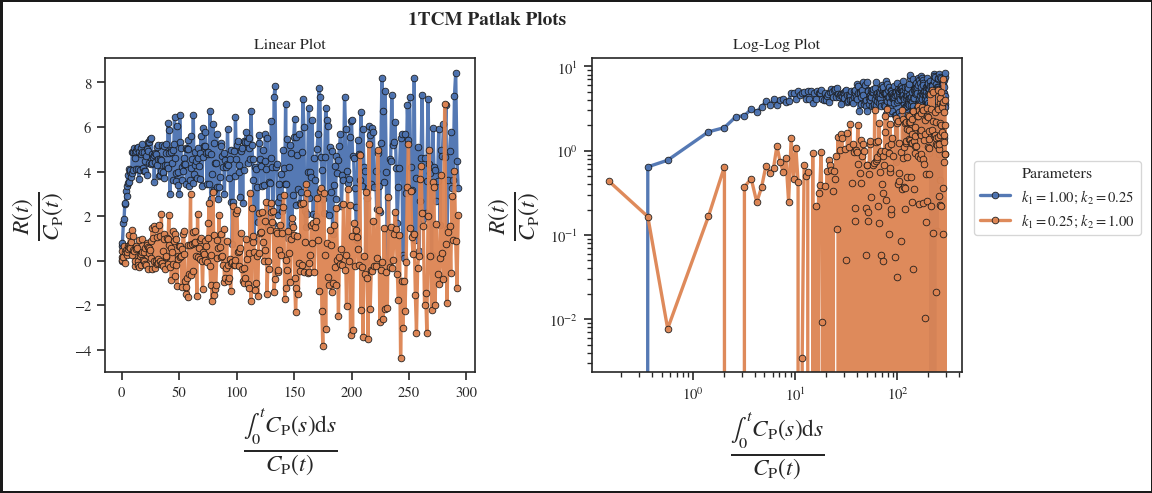

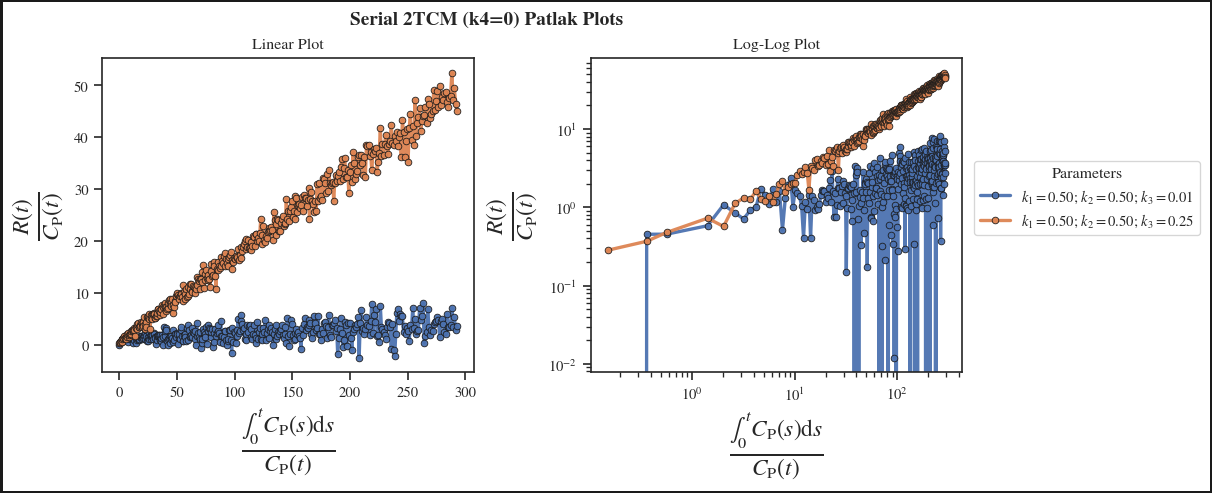

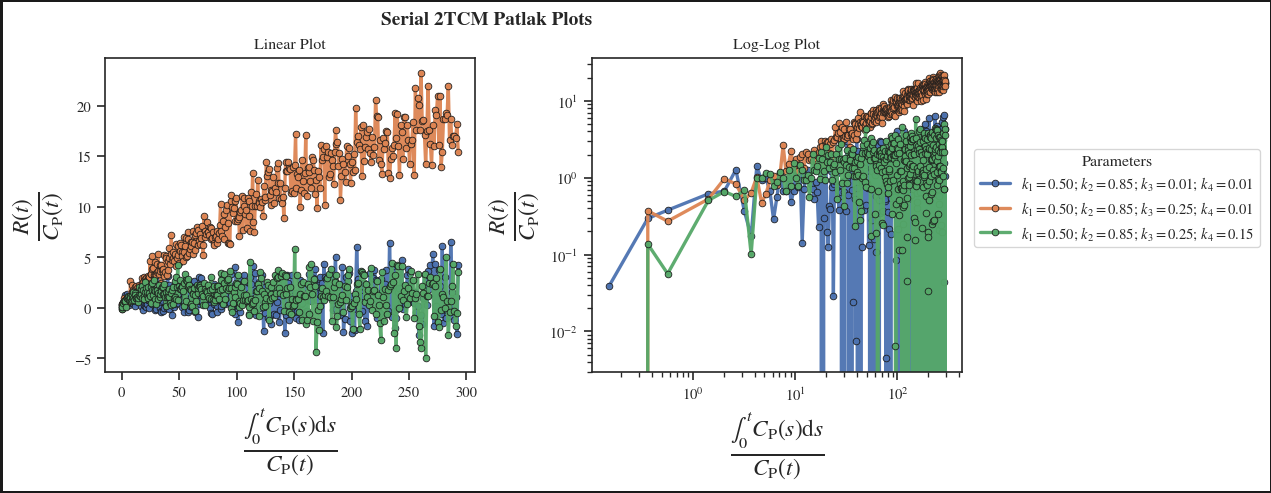

In [23]:
for a_model, num in MODELS_NUMS.items():
    myFig, myAx = plt.subplots(1, 2, constrained_layout=True, figsize=[8, 4], dpi=120, linewidth=3.0, edgecolor='k')
    for i in range(num):
        _params = model_params[a_model][f"set-{i:02}"]
        _tTAC = all_tacs['gaussian-noise'][a_model][f"set-{i:02}"]
        patlak_vars = gen_patlak_plot(pTAC, _tTAC)
        
        myAx[0].plot(*patlak_vars, '.-', alpha=0.95, lw=2, label=params_dict_to_label(_params['params']), color=f"C{i}",
                     ms=8, mec='k', mew=0.5)
        myAx[1].plot(*patlak_vars, '.-', alpha=0.95, lw=2, color=f"C{i}", ms=8, mec='k', mew=0.5)

    myAx[0].set(title=f"Linear Plot")
    myAx[1].set(title=f"Log-Log Plot", xscale='log', yscale='log')
    myAx[0].set_xlabel(patlak_xLab, fontsize=20)
    myAx[0].set_ylabel(patlak_yLab, fontsize=20)
    myAx[1].set_xlabel(patlak_xLab, fontsize=20)
    myAx[1].set_ylabel(patlak_yLab, fontsize=20)
    myFig.suptitle(f"{_params['model']} Patlak Plots", fontweight='bold')
    myFig.legend(bbox_to_anchor=(1.0, 0.6), loc='center left', title='Parameters')
    plt.show()

#### Comparing Values

In [24]:
for a_model, num in MODELS_NUMS.items():
    print('-'*35)
    print(f"Model: {a_model}")
    print(f"    {'K1 (true)':<10}, {'K1 (calc)':<10}, {'|diff.|':<10}")
    for i in range(num):
        _params = model_params[a_model][f"set-{i:02}"]
        _tTAC   = all_tacs['gaussian-noise'][a_model][f"set-{i:02}"][1]
        true_vals = tcm_calculate_patlak_from_model(_params)
        calc_vals = pet_gph.patlak_analysis(input_tac_values=pTAC[1],
                                           region_tac_values=_tTAC,
                                           tac_times_in_minutes=pTAC[0],
                                           t_thresh_in_minutes=30.0)
        k1_true = true_vals['slope']
        k1_calc = calc_vals[0]
        diff    = np.abs(k1_true - k1_calc)
        print(f"    {k1_true:<10.5f}, {k1_calc:<10.5f}, {diff:<10.5f}")
    print('-'*35)

-----------------------------------
Model: 1tcm
    K1 (true) , K1 (calc) , |diff.|   
    0.00000   , -0.00083  , 0.00083   
    0.00000   , 0.00151   , 0.00151   
-----------------------------------
-----------------------------------
Model: serial_2tcm_k4zero
    K1 (true) , K1 (calc) , |diff.|   
    0.00980   , 0.00950   , 0.00031   
    0.16667   , 0.16477   , 0.00190   
-----------------------------------
-----------------------------------
Model: serial_2tcm
    K1 (true) , K1 (calc) , |diff.|   
    0.00000   , 0.00164   , 0.00164   
    0.00000   , 0.05464   , 0.05464   
    0.00000   , -0.00347  , 0.00347   
-----------------------------------


### Logan Analysis

#### Plots

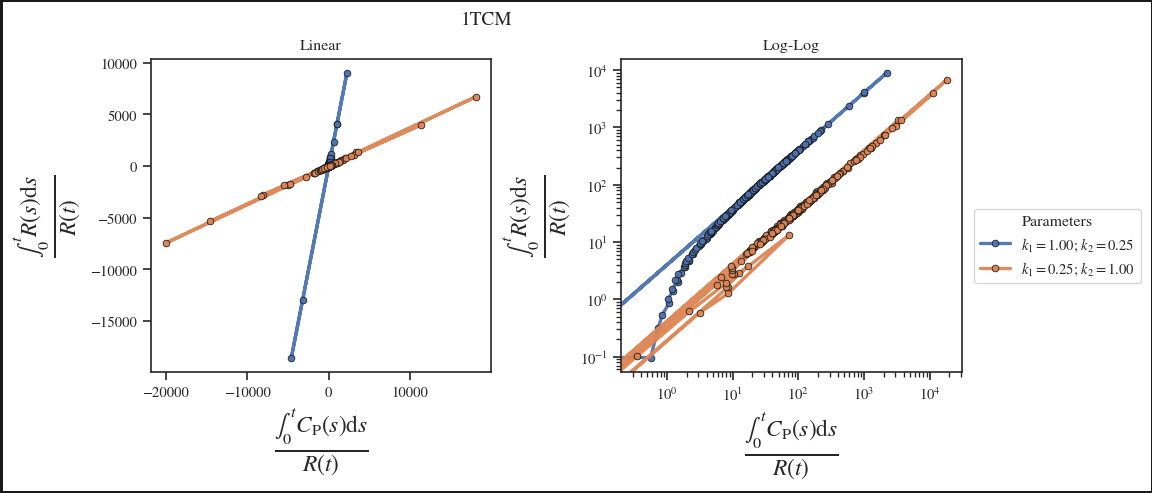

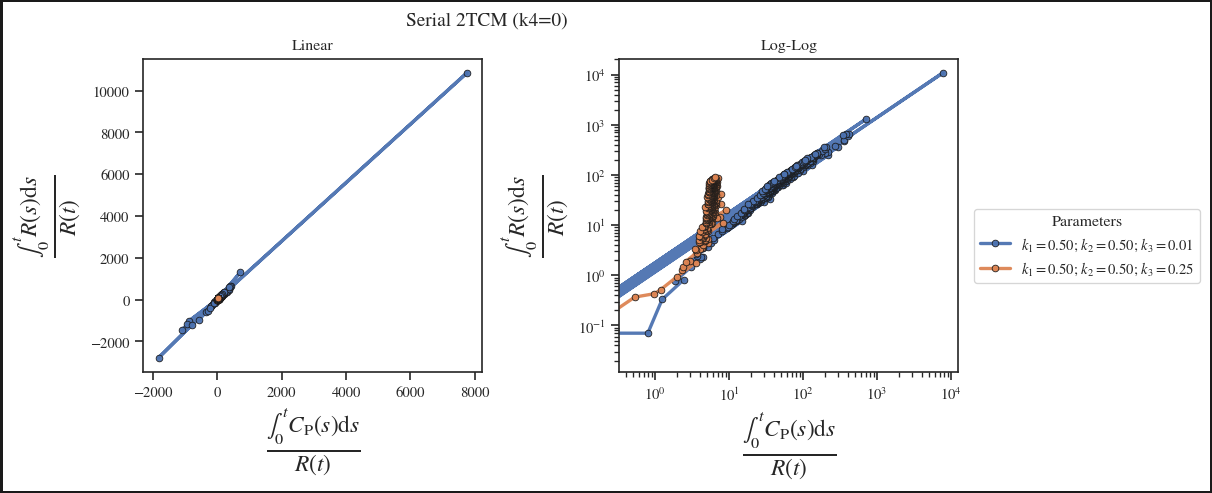

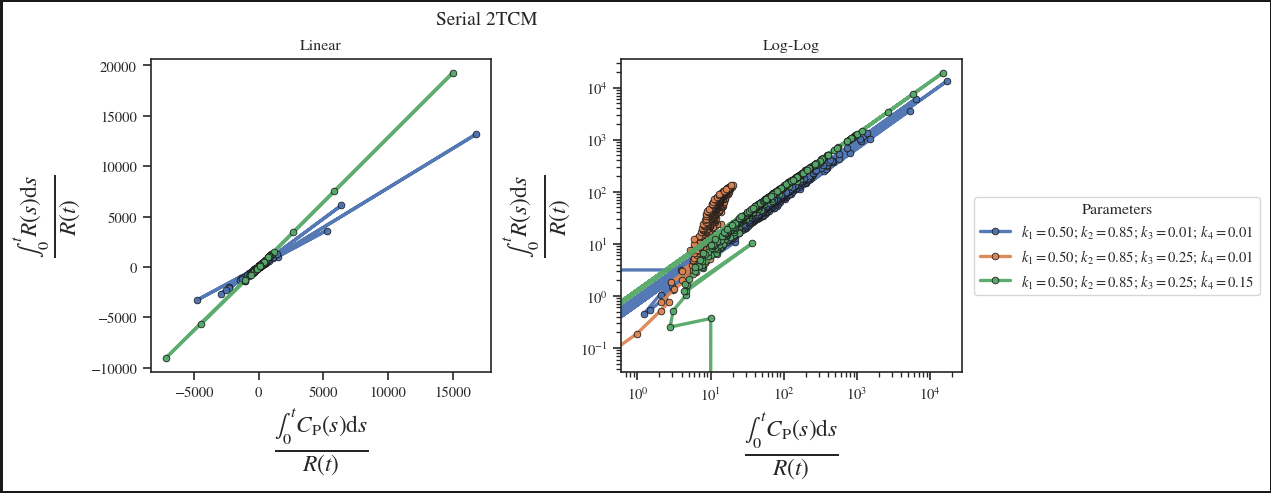

In [25]:
for a_model, num in MODELS_NUMS.items():
    myFig, myAx = plt.subplots(1, 2, constrained_layout=True, figsize=[8, 4], dpi=120, linewidth=3.0, edgecolor='k')
    for i in range(num):
        _params = model_params[a_model][f"set-{i:02}"]
        _tTAC = all_tacs['gaussian-noise'][a_model][f"set-{i:02}"]
        logan_vars = gen_logan_plot(pTAC, _tTAC)
        
        myAx[0].plot(*logan_vars, '.-', alpha=0.95, lw=2, 
                     label=params_dict_to_label(_params['params']), color=f"C{i}", ms=8, mec='k', mew=0.5)
        myAx[1].plot(*logan_vars, '.-', alpha=0.95, lw=2, color=f"C{i}", ms=8, mec='k', mew=0.5)

    myAx[0].set(title=f"Linear")
    myAx[1].set(title=f"Log-Log", xscale='log', yscale='log')
    myAx[0].set_xlabel(logan_xLab, fontsize=20)
    myAx[0].set_ylabel(logan_yLab, fontsize=20)
    myAx[1].set_xlabel(logan_xLab, fontsize=20)
    myAx[1].set_ylabel(logan_yLab, fontsize=20)
    myFig.suptitle(f"{_params['model']}")
    myFig.legend(bbox_to_anchor=(1.0, 0.5), loc='center left', title='Parameters')
    plt.show()

#### Comparing Values

###### Slope

In [26]:
for a_model, num in MODELS_NUMS.items():
    # print('-'*35)
    print(f"Model: {a_model}")
    print(f"    {'slope (true)':<15}, {'slope (calc)':<15}, {'|diff.|':<15}")
    for i in range(num):
        _params = model_params[a_model][f"set-{i:02}"]
        _tTAC   = all_tacs['gaussian-noise'][a_model][f"set-{i:02}"][1]
        true_vals = tcm_calculate_logan_from_model(_params)
        calc_vals = pet_gph.logan_analysis(input_tac_values=pTAC[1],
                                           region_tac_values=_tTAC,
                                           tac_times_in_minutes=pTAC[0],
                                           t_thresh_in_minutes=30.0)
        k1_true = true_vals['slope']
        k1_calc = calc_vals[0]
        diff    = np.abs(k1_true - k1_calc)
        print(f"    {k1_true:<15.5f}, {k1_calc:<15.5f}, {diff:<15.5f}")
    # print('-'*35)
    print()

Model: 1tcm
    slope (true)   , slope (calc)   , |diff.|        
    4.00000        , 4.03688        , 0.03688        
    0.25000        , 0.36184        , 0.11184        

Model: serial_2tcm_k4zero
    slope (true)   , slope (calc)   , |diff.|        
    nan            , 1.41434        , nan            
    nan            , 16.98707       , nan            

Model: serial_2tcm
    slope (true)   , slope (calc)   , |diff.|        
    0.29412        , 0.81940        , 0.52528        
    0.02262        , 9.88850        , 9.86587        
    0.22059        , 1.28152        , 1.06093        



##### Intercept

In [27]:
for a_model, num in MODELS_NUMS.items():
    # print('-'*35)
    print(f"Model: {a_model}")
    print(f"    {'int. (true)':<15}, {'int. (calc)':<15}, {'|diff.|':<15}")
    for i in range(num):
        _params = model_params[a_model][f"set-{i:02}"]
        _tTAC   = all_tacs['noise-free'][a_model][f"set-{i:02}"][1]
        true_vals = tcm_calculate_logan_from_model(_params)
        calc_vals = pet_gph.logan_analysis(input_tac_values=pTAC[1],
                                           region_tac_values=_tTAC,
                                           tac_times_in_minutes=pTAC[0],
                                           t_thresh_in_minutes=30.0)
        k1_true = true_vals['intercept']
        k1_calc = calc_vals[1]
        diff    = np.abs(k1_true - k1_calc)
        print(f"    {k1_true:<15.5f}, {k1_calc:<15.5f}, {diff:<15.5f}")
    # print('-'*35)
    print()

Model: 1tcm
    int. (true)    , int. (calc)    , |diff.|        
    -4.00000       , -3.86192       , 0.13808        
    -1.00000       , -0.85918       , 0.14082        

Model: serial_2tcm_k4zero
    int. (true)    , int. (calc)    , |diff.|        
    nan            , -45.00171      , nan            
    nan            , -1263.28061    , nan            

Model: serial_2tcm
    int. (true)    , int. (calc)    , |diff.|        
    -2.85045       , -21.95450      , 19.10404       
    -31.54062      , -112.52420     , 80.98358       
    -3.70868       , -7.20086       , 3.49218        

